# 作成したモデルのdeployとserving

このハンズオンでは、Vertex AIにモデルをデプロイし、推論APIとして利用できるようにしていきます。

先ほど作成した犬種/猫種判別モデルをデプロイすることで、その手順を確認していきましょう。

In [2]:
%%bash
USER=rio # 自分の名前
BUCKET=mixi-ml-handson-2023
VERSION=001
REGION=asia-northeast1

gcloud ai models upload \
  --region=${REGION} \
  --display-name=oxford-pet-${USER} \
  --container-image-uri=asia-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest \
  --artifact-uri=gs://${BUCKET}/${USER}/${VERSION}

gcloud ai models list \
  --region=${REGION} \
  --filter=oxford-pet-${USER}
    
gcloud ai endpoints create \
  --region=${REGION} \
  --display-name=oxford-pet-${USER}

MODEL_ID             DISPLAY_NAME
6433163369280176128  oxford-pet-rio


Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Waiting for operation [5447448995955736576]...
......................................done.
Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Waiting for operation [5883172259903832064]...
...................done.
Created Vertex AI endpoint: projects/627612299023/locations/asia-northeast1/endpoints/7787058007258431488.


実行が終わったら、出力されたMODEL_IDと、endpointを作成した際に出力された`ENDPOINT_ID` `・・・/asia-northeast1/endpoints/<ENDPOINT_ID>`を使って、endpointにmodelをdeployします。

In [3]:
%%bash

USER=username # 自分の名前
REGION=asia-northeast1
MODEL_ID=6433163369280176128
ENDPOINT_ID=7787058007258431488

gcloud ai endpoints deploy-model ${ENDPOINT_ID} \
  --region=${REGION} \
  --model=${MODEL_ID} \
  --display-name=oxford-pet-${USER}

Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Waiting for operation [9215835984157999104]...
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


上記コードの実行には数分の時間がかかります。

versionの作成が完了したら、このendpointにリクエストを投げて結果が返ってくるか確認してみます。  
まず、02と同じようにデータセットを用意していきましょう。

In [16]:
import tensorflow as tf
import numpy as np

image_size = (200, 200)
batch_size = 32
DATASET_DIR = "../02_transfer_learning/dataset"

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1111,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7392 files belonging to 37 classes.
Using 1478 files for validation.


データセットが用意できたら、endpointにリクエストを投げて結果を受け取るメソッドを作成します。

In [23]:
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

PROJECT_ID = 'tanpopo-ml'
ENDPOINT_ID = '7787058007258431488'
REGION = "asia-northeast1"

def predict_json(instances):    
    aiplatform.init(project=PROJECT_ID, location=REGION)
    endpoint = aiplatform.Endpoint(ENDPOINT_ID)
    instances = [json_format.ParseDict(s, Value()) for s in instances]
    response = endpoint.predict(instances=instances)
    return response.predictions

これで結果を受け取る部分はできたので、02で作成したpredict_datasetメソッドのresult部分を、作成したpredict_jsonメソッドに変えてみましょう。

In [21]:
def predict_dataset():
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i].numpy()
            plt.imshow(image.astype("uint8"))
            norm_img = image / 255.0
            norm_img = [norm_img.tolist()]
            result =  predict_json([norm_img])
            plt.title(
                "label:" + val_data.class_names[np.argmax(labels[i])] +
                "\npredict:" + val_data.class_names[np.argmax(result[0])]
            )
        plt.axis("off")

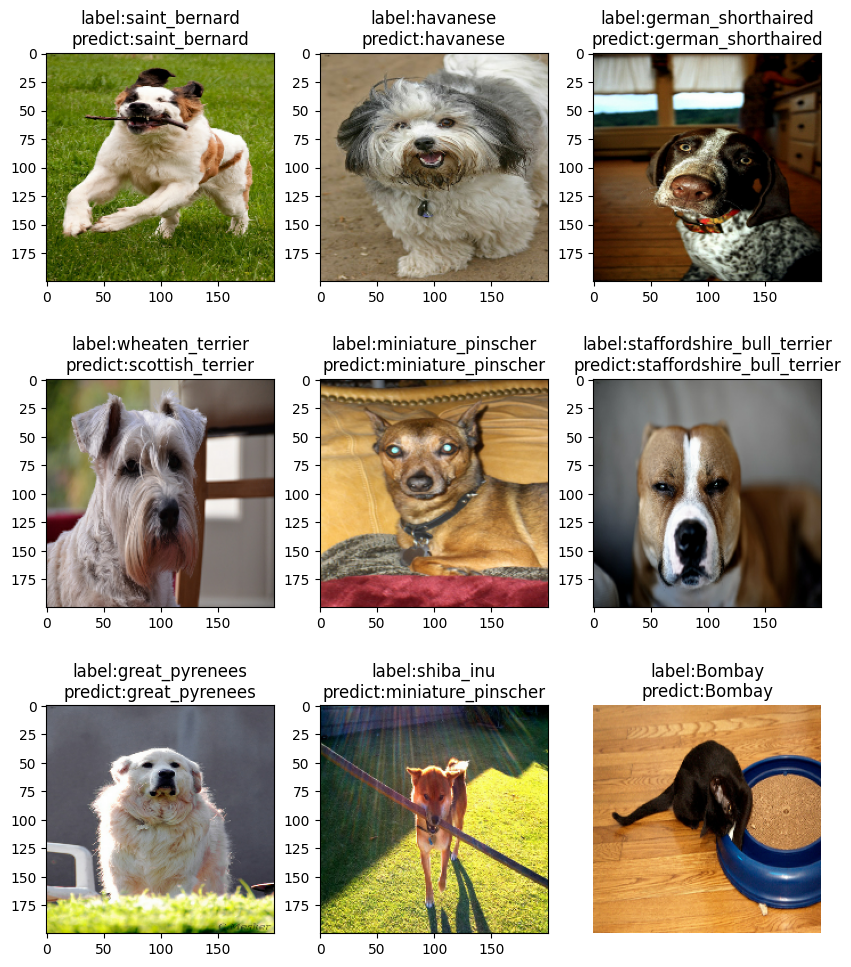

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/google/api_core/grpc_helpers.py", line 65, in error_remapped_callable
    return callable_(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/grpc/_channel.py", line 1030, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/opt/conda/lib/python3.7/site-packages/grpc/_channel.py", line 910, in _end_unary_response_blocking
    raise _InactiveRpcError(state)  # pytype: disable=not-instantiable
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "{
    "error": "input must be 4-dimensional[200,200,3]\n\t [[{{function_node __inference_pruned_67625}}{{node predict/MobilenetV2/Conv/Relu6}}]]"
}"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:172.217.26.234:443 {created_time:"2023-04-19T17:35:43.265624784+00:00", grpc_status:3, grpc_message:"{\n    \"error\": \"input must be 

In [24]:
import matplotlib.pyplot as plt
labels = val_data.class_names

plt.figure(figsize=(10, 12))
predict_dataset()

これで、modelの部分を推論APIに置き換えることができました。

## Gradioを使って犬種/猫種判別を行うデモアプリを作成する

model部分のAPI化ができたので、機械学習を使った簡単なデモアプリを作ってみましょう。

まず、お手軽にML系のwebアプリケーションが作成できるgradioをinstallします。

In [166]:
!pip install gradio

完了したら、デモアプリを作成してみましょう。  
コード実行ができたら、public URLを確認してみてください。

In [26]:
import gradio as gr

labels = val_data.class_names

def predict(image):
    image = image / 255.0
    image = image.tolist()
    pred = predict_json([image])[0]
    confidences = {labels[i]: pred[i] for i in range(len(labels))}    
    return confidences

demo = gr.Interface(predict, gr.Image(shape=(200, 200)), outputs=gr.outputs.Label(num_top_classes=5))

# <todo> ""部分に独自のuserとpasswordを入力してください。
# share=Trueになっていると、public URLとして公開されるため、必ず各自でpassを設定して入るようにしてください。
demo.launch(share=True, auth=("", ""))

/home/jupyter/.local/lib/python3.7/site-packages/gradio/outputs.py:198: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/home/jupyter/.local/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://76243f147bab4adb35.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


犬種/猫種判定アプリが作れていましたでしょうか。  
データセットにない犬、猫などを投げてみて、正しく判別できるか試してみてください。  
犬種の画像は、https://www.min-inuzukan.com/
猫種の画像は、https://www.min-nekozukan.com/ にあります。